In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

import wio
import wind
import windCAD

In [ ]:
caseDir = r'D:\tempData_depot\simData_CandC\wt_tngE2/'
# velTH = r'E:\TNG\Profiles\RawData\tngE2Fr1/'
dataDirHFPI = r'E:\TNG\rawHFPI\tngE2p1/'

In [ ]:
file = r'D:\tempData_depot\simData_CandC\tngE2\tngE2Fr1_profile.csv'
temp = pd.read_csv(file)

dt = 3.7890e-04
H = 0.08

# file = r'D:\tempData_depot\simData_CandC\tngE2\tngE2Fr1_TH-UofT.csv'
# U_TH = np.transpose((pd.read_csv(file)).to_numpy())
# file = r'D:\tempData_depot\simData_CandC\tngE2\tngE2Fr1_TH-VofT.csv'
# V_TH = np.transpose((pd.read_csv(file)).to_numpy())
# file = r'D:\tempData_depot\simData_CandC\tngE2\tngE2Fr1_TH-WofT.csv'
# W_TH = np.transpose((pd.read_csv(file)).to_numpy())

file = caseDir+'tngE2Fr1_TH-UofT.npy'
U_TH = np.load(file)
file = caseDir+'tngE2Fr1_TH-VofT.npy'
V_TH = np.load(file)
file = caseDir+'tngE2Fr1_TH-WofT.npy'
W_TH = np.load(file)

vel = wind.profile(name="BLWT-E2", Z=temp.Z,UofT=U_TH,VofT=V_TH,WofT=W_TH,H=H,dt=dt,nSpectAvg=64)


In [ ]:


file_pssd = dataDirHFPI+'TNGp1E02R001P001a.pssd'
file_pssr = dataDirHFPI+'TNGp1E02R001P001a.pssr'

cp_data,analog,WTTDATALOG = wio.readPSSfile(file_pssr,file_pssd)

mainRefPitotChnlIdx = 2
fps2mps = 0.3048
UpitotOfT = 29.917 * np.sqrt(analog[:,mainRefPitotChnlIdx]) * fps2mps
Upitot = np.mean(UpitotOfT)
Zpitot = 1.48
AoA = WTTDATALOG["APPSPE"][0][0][0][0][0][0][0][16][0][0]
sampleRate = WTTDATALOG["APPSPE"][0][0][0][0][0][0][0][12][0][0]


tapFile = caseDir+'tngTapDefinition.csv'
tapGeom = pd.read_csv(tapFile)

In [ ]:

# x = UpitotOfT
# # x = WTTDATALOG["APPSPE"][0][0][0][0][0][0][0][12][0][0]
# print(np.shape(x))
# print(np.mean(x))

# print(tapGeom.to_numpy()[:,2:4])

In [ ]:
ttu = wind.building('TTU',H=0.08,B=0.2744,D=0.183,He=0.078094,
                    tapNo=tapGeom.tapNo,tapFaceID=tapGeom.faceID,
                    tapCoord2D=tapGeom.to_numpy()[:,2:4],
                    lScl=1/50)

cp = wind.Cp(name='tngE1_0000',bldg=ttu,refProfile=vel,AoA=AoA,
                samplingFreq=sampleRate,CpOfT=cp_data.transpose(),Zref_input=Zpitot,
                Uref_input=Upitot)

In [ ]:
plt.plot(cp.CpStd,'.k')
# print(cp_data.shape)

In [ ]:
# from scipy.spatial import Voronoi, voronoi_plot_2d

# points = np.array([[xMid, 0], [0, 1.5], [0, 2], [1, 0], [1.2, 1], [1, 2],
#                    [2, 0], [2, 1], [2.05, 2]])
# vor = Voronoi(points,)

# fig = voronoi_plot_2d(vor)
# plt.show()

import shapely.geometry as shp
from shapely.ops import voronoi_diagram

# points =  shp.MultiPoint([(0, 0), (1, 1), (0, 2), (2, 2), (3, 1), (1, 0)])

# regions = voronoi_diagram(points)

# print(regions.bounds)


x = np.array([(3, 1.5), (2, 4), (5, 3), (5, 4.5)])
points = shp.MultiPoint(x)
# points = shp.MultiPoint([(3, 1.5), (2, 4), (5, 3), (5, 4.5)])
bound = shp.Polygon([(1, 1), (6, 1), (6.5, 5), (1, 5)])

regions = voronoi_diagram(points)

tribs = []

for g in regions.geoms:
    newRig = bound.intersection(g)
    tribs.append(newRig)
    x,y = newRig.exterior.xy
    plt.plot(x,y)

print(tribs)
# print([region.wkt for subzone in regions])

In [ ]:

# polygon_A = shp.Polygon([(1, 1), (6, 1), (6.5, 5), (1, 5)])
# polygon_B = shp.Polygon([(0, 1.5), (1.5, 1.5), (1.5, 2), (2.1, 2), (1.000000000000001, 2.5), (1.5, 2.5), (1.5, 3), (0, 3)])
polygon_A = shp.Polygon([(-0.1372, 0.02), (-0.05, 0.05), (0.1, 0.02), (0.1, 0.091519855), (-0.1372, 0.091519855), (-0.1372, 0.02)])
polygon_B = shp.Polygon([(0.0137751838235294, 0.05978291934375), (0.0137751838235294, 0.06782890303125), (0.0137751838235294, 0.06782890303125), (0.0209696691176471, 0.06782890303125), (0.0209696691176471, 0.05978291934375), (0.0209696691176471, 0.05978291934375), (0.0137751838235294, 0.05978291934375)])

overlap = getIntersection(polygon_A,polygon_B,allowMultiPolygon=False)
allCol = shp.MultiPolygon((polygon_A, polygon_B))

plt.figure(figsize=[10,6])
x,y = polygon_A.exterior.xy
plt.plot(x,y,'-b',lw=0.5)
x,y = polygon_B.exterior.xy
plt.plot(x,y,'-r',lw=0.5)
if overlap is not None:
    if overlap.geom_type == "Polygon":
        x,y = overlap.exterior.xy
        plt.plot(x,y,'--k',lw=1.5)
    elif overlap.geom_type == "MultiPolygon":
        for ovlp in overlap.geoms:
            x,y = ovlp.exterior.xy
            plt.plot(x,y,'--k',lw=1.5)
plt.show()

In [ ]:
import shapely.ops
import warnings

def getIntersection(pA, pB, allowMultiPolygon=True):
    from shapely.validation import make_valid
    
    # pA = shp.Polygon([])
    # pB = shp.Polygon([])
    # overlap = shp.Polygon([])
    
    if not pA.is_valid:
        pA = make_valid(pA)
        if pA.geom_type == "MultiPolygon":
            temp = pA
            pA = None
            for geom in temp.geoms:
                if geom.area/temp.area > 0.001:
                    if pA is None:
                        pA = geom
                    else:
                        pA = pA.union(geom)
        elif pA.geom_type == "GeometryCollection":
            temp = pA
            pA = None
            for geom in temp.geoms:
                if geom.area/temp.area > 0.001:
                    if geom.geom_type == "Polygon":
                        if pA is None:
                            pA = geom
                        else:
                            pA = pA.union(geom)

    if not pB.is_valid:
        pB = make_valid(pB)
        if pB.geom_type == "MultiPolygon":
            temp = pB
            pB = None
            for geom in temp.geoms:
                if geom.area/temp.area > 0.001:
                    if pB is None:
                        pB = geom
                    else:
                        pB = pB.union(geom)
        elif pB.geom_type == "GeometryCollection":
            temp = pB
            pB = None
            for geom in temp.geoms:
                if geom.geom_type == "Polygon":
                    if geom.area/temp.area > 0.001:
                        if pB is None:
                            pB = geom
                        else:
                            pB = pB.union(geom)
    
    overlap = None
    if pA.is_valid and pB.is_valid:
        if pA.intersects(pB):
            overlap = pA.intersection(pB)
            if overlap.geom_type == "Polygon":
                pass
            elif overlap.geom_type == "GeometryCollection":
                temp = overlap
                overlap = None
                for geom in temp.geoms:
                    if geom.geom_type == "Polygon":
                        if overlap is None:
                            overlap = geom
                        else:
                            overlap = overlap.union(geom)
            elif overlap.geom_type == "MultiPolygon":
                if allowMultiPolygon:
                    warnings.warn("MultiPolygon obtained while intersecting. Make sure that the receiving function is capable of treating it.")
                else:
                    overlap = None
            elif overlap.geom_type == "LineString":
                overlap = None
            elif overlap.geom_type == "Point":
                overlap = None
            else:
                raise Exception(f"Unknown geometry type {overlap.geom_type} obtained while intersecting.")
        elif pA.within(pB):
            overlap = pA
        elif pB.within(pA):
            overlap = pB
        else:
            overlap = None
    else:
        print("One or both of the input geometries are invalid to perform intersection.")
        print(f"geom A: {pA}")
        print(f"geom B: {pB}")
        plt.figure()
        x,y = pA.exterior.xy
        plt.plot(x,y,'-b',lw=1.0)
        x,y = pB.exterior.xy
        plt.plot(x,y,'-r',lw=1.0)
        plt.axis('equal')
        overlap = None
    
    return overlap

def intersects(geomA,geomB):
    yesItDoes = geomA.intersects(geomB) or geomA.within(geomB) or geomB.within(geomA)
    return yesItDoes

def sortVoronoi(coords,tribs=None):
    points = shp.MultiPoint(coords)
    if tribs is None:
        tribs = voronoi_diagram(coords)

    idxs = []
    for t,trib in enumerate(tribs.geoms):
        for p,pt in enumerate(points.geoms):
            if pt.within(trib):
                idxs.append(p)
    tribs = shp.MultiPolygon([tribs.geoms[i] for i in idxs])
    return tribs

def trimmedVoronoi(bound,coords):
    inftyTribs = voronoi_diagram(shp.MultiPoint(coords))
    boundPolygon = shp.Polygon(bound)
    tribs = []
    for g in inftyTribs.geoms:
        newRig = getIntersection(boundPolygon,g)
        if newRig is not None:
            tribs.append(newRig)
        else:
            continue
    idx = []
    for ic in range(np.shape(coords)[0]):
        for it,trib in enumerate(tribs):
            if shp.Point(coords[ic,:]).within(trib):
                idx.append(it)
                break
    tribs = shp.MultiPolygon([tribs[i] for i in idx])
    
    return tribs

def meshRegionWithPanels(region,area,minAreaFactor=0.5,debug=False):
    from shapely.ops import voronoi_diagram
    if debug:
        import matplotlib.pyplot as plt
        # print(f"Region: shape {region.shape}, {region}\n")
        # print(f"NominalArea = {area}")

    # generate a uniform grid of panel center points covering the extents of the region
    xMin, xMax = min(region[:,0]), max(region[:,0])
    yMin, yMax = min(region[:,1]), max(region[:,1])
    Dx = xMax-xMin
    Dy = yMax-yMin
    N = max(int(np.round(Dx/np.sqrt(area),0)), 1)
    dx = Dx/N
    M = max(int(np.round(Dy/np.sqrt(area),0)), 1)
    dy = Dy/M

    x = np.linspace(xMin+dx/2,xMax-dx/2,N-1) if N > 2 else (xMax-xMin)/2.0
    y = np.linspace(yMin+dy/2,yMax-dy/2,M-1) if M > 2 else (yMax-yMin)/2.0
    X,Y = np.meshgrid(x,y)
    XY = np.concatenate((np.reshape(X,[-1,1]), np.reshape(Y,[-1,1])),axis=1)

    # generate the panels with the regular points. Take a note of the panels with area less than minAreaFactor*targetPanelArea for merging
    points = shp.MultiPoint(XY)
    regions = voronoi_diagram(points)
    bound = shp.Polygon(region)

    if debug:
        # print(f"xRange = {Dx}, yRange = {Dy}")
        # print(f"N = {N}, M = {M}")
        # plt.figure(figsize=[15,10])
        # plt.plot(region[:,0],region[:,1],'-k',lw=2)
        # plt.plot(X,Y,'.k')
        plt.figure(figsize=[15,10])
        x,y = bound.exterior.xy
        plt.plot(x,y,'-b',lw=3)
        plt.axis('equal')

    panels = []
    goodPts = []
    for g in regions.geoms:
        newRig = getIntersection(bound,g)
        if newRig is not None:
            panels.append(newRig)
        else:
            continue
        # x,y = newRig.exterior.xy
        # plt.plot(x,y,'-r',lw=0.5)
        
        if newRig.area > minAreaFactor*area:
            center = newRig.centroid
            goodPts.append(center.xy)
    goodPts = np.reshape(np.asarray(goodPts,dtype=float),[-1,2])

    # regenerate the panels without those that had areas less than minAreaFactor*targetPanelArea
    points = shp.MultiPoint(goodPts)
    regions = voronoi_diagram(points)

    if debug:
        plt.plot(goodPts[:,0],goodPts[:,1],'.k')

    panels = []
    summedArea = 0
    areas = []
    for g in regions.geoms:
        newRig = getIntersection(bound,g)
        if newRig is not None:
            panels.append(newRig)
        else:
            continue
        
        areas.append(newRig.area)
        x,y = newRig.exterior.xy
        panels.append(newRig)
        # print(f"      xy shape of panel_i: {np.shape(xy)},    total panels shape: {np.shape(panels)}")
        
        if debug:
            summedArea += newRig.area
            plt.plot(x,y,'-r',lw=0.5)

    if len(panels) == 0:
        panels.append(bound)

    if debug:
        # plt.xlim([-0.15,0.12])
        # plt.ylim([-0.03,0.05])
        print(f"Zone area = {bound.area}, summed area = {summedArea}")
        plt.axis('equal')
        plt.show()

    # print(f"Shape: {len(panels)}")
    panels = np.asarray(panels,dtype=object)
    return panels, areas


def calculateTapWeightsPerPanel(panels,tapsAll,tapIdxAll):
    wghtTolerance = 0.0000001
    weights = np.array([],dtype=object)
    tapIdxs = np.array([],dtype=object)
    overlaps = ()
    for pnl in panels:
        A = pnl.area
        w = []
        idx = []
        ovlps = []
        for tap,i in zip(tapsAll,tapIdxAll):
            ovlp = getIntersection(pnl,tap)
            if ovlp is not None:
                idx.append(i)
                w.append(ovlp.area/A)
                ovlps.append(ovlp)
            else:
                continue
        if abs(sum(w)-1) > wghtTolerance:
            warnings.warn(f"The sum of area weights {sum(w)} from involved taps does not add up to 1 within the tolerance of 0.1%.")
        weights = np.append(weights, w)
        tapIdxs = np.append(tapIdxs, idx)
        overlaps += (ovlps,)
    
    return weights, tapIdxs, overlaps

In [ ]:
import shapely.geometry as shp
from shapely.ops import voronoi_diagram

xMin = -0.1372
xMax = 0.1372
yMin = 0
yMax = 0.091519855
bound = [(xMin, yMin), (xMin, yMax),(xMax, yMax),(xMax, yMin),(xMin, yMin),]

file = r"D:\tempData_depot\simData_CandC\tapCoords2D.csv"
data = pd.read_csv(file)
taps = data.to_numpy(dtype=float)[:,1:]
tapNos = data.to_numpy(dtype=float)[:,0]
idxOrig = range(len(tapNos))

tribs = trimmedVoronoi(bound,taps) 


bound = shp.Polygon(bound)
# # points = shp.MultiPoint(taps)
# # regions = voronoi_diagram(points)
# regions = sortedVoronoi(taps)

x,y = bound.exterior.xy
plt.figure(figsize=[20,10])
plt.plot(x,y,'-k',lw=1.5)

for i,t in enumerate(tribs):
    if i < 50:
        continue
    x,y = t.exterior.xy
    plt.plot(x,y,':r',lw=0.5)
    plt.plot(taps[i,0],taps[i,1],'.k')

plt.axis('equal')


In [ ]:
import warnings
# warnings.filterwarnings("default")
warnings.filterwarnings("error")

xMid = 0.1
xMid2 = 0.11
yMid = 0.02
yMid2 = 0.025
yMid3 = (yMid+yMax)*0.6
zones = [
    [
        [
            np.array([(xMid, yMin), (xMax, yMin), (xMax, yMid), (xMid, yMid), (xMid, yMin)]), # subzone 1
        ], # Corner zone
        [
            np.array([(xMin, yMin), (xMid, yMin), (xMid, yMid), (-0.05, 0.05), (xMin, yMid), (xMin, yMin)]), # subzone 1
            np.array([(xMid, yMid3-0.01), (xMax, yMid3), (xMax, yMax), (xMid, yMax), (xMid, yMid3-0.01)]), # subzone 2
            np.array([(xMid, yMid), (xMax, yMid), (xMax, yMid3), (xMid, yMid3-0.01), (xMid, yMid)]), # subzone 3
        ], # Edge zone
        [
            np.array([(xMin, yMid), (-0.05, 0.05), (xMid, yMid), (xMid, yMax), (xMin, yMax), (xMin, yMid)]), # subzone 1
        ], # Corner zone
    ], # NBCC
    [
        [
            np.array([(xMid2, yMin), (xMax, yMin), (xMax, yMid2), (xMid2, yMid2), (xMid2, yMin)]), # subzone 1
        ], # Corner zone
        [
            np.array([(xMin, yMin), (xMid2, yMin), (xMid2, yMid2), (xMin, yMid2), (xMin, yMin)]), # subzone 1
            np.array([(xMid2, yMid2), (xMax, yMid2), (xMax, yMax), (xMid2, yMax), (xMid2, yMid2)]), # subzone 2
        ], # Edge zone
        [
            np.array([(xMin, yMid2), (xMid2, yMid2), (xMid2, yMax), (xMin, yMax), (xMin, yMid2)]), # subzone 1
        ], # Corner zone
    ], # ASCE
    ]
"""                 
list of array of arrays: vertices in local coord sys of each subzone (r) belonging to each zone (z or a) from each code.
  e.g., zones = 
        [ [[z1r1,2], [z1r2,2], ... [z1rN1,2]], [[z2r1,2], [z2r2,2], ... [z2rN2,2]], ....... [[zMr1,2], [zMr2,2], ... [zMrNM,2]],  # NBCC
          [[a1r1,2], [a1r2,2], ... [a1rN1,2]], [[a2r1,2], [a2r2,2], ... [a2rN2,2]], ....... [[aQr1,2], [aQr2,2], ... [aQrNQ,2]] ] # ASCE
         NBCC has M number of zones. Its zone 1 has N1 number of subzones defined by the list vertices in zones[0][0]
         zones[1][Q][NQ] is the coordinates of NQ'th subzone belonging to the Q'th zone of ASCE
If you don't want to apply any zoning, put the face vertices as [[[[Nv,2],],],]
"""


# problematic areas: 2e-4 (NBCC), 
# edge zone doesn't divide properly: 3e-4 with ASCE  np.array([(xMid2, yMid2), (xMax, yMid2), (xMax, yMax), (xMid2, yMax), (xMid2, yMid2)]), # subzone 2  
nominalPanelAreas = [5e-5,1e-4,1.001e-4] # 7e-5, 8e-5, 9e-5] #5e-5, 1e-4]


panels = ()
pnlWeights = ()
tapIdxByPnl = ()
for c,code in enumerate(zones):
    panels_c = ()
    pnlWeights_c = ()
    tapIdxByPnl_c = ()
    for z,zone in enumerate(code):
        panels_z = ()
        pnlWeights_z = ()
        tapIdxByPnl_z = ()
        for a,area in enumerate(nominalPanelAreas):
            # if area >= bound.area:
            #     continue
            panels_a = np.asarray([],dtype=object)
            pnlWeights_a = np.asarray([],dtype=object)
            tapIdxByPnl_a = np.asarray([],dtype=object)
            for r,subzone in enumerate(zone):
                pnls,areas = meshRegionWithPanels(subzone,area,debug=False)
                panels_a = np.append(panels_a, pnls)

                tapsInRgn = []
                idxInRgn = []
                regPlgn = shp.Polygon(subzone)
                for i,tap in zip(idxOrig,tribs.geoms):
                    if intersects(tap,regPlgn):
                        tapsInRgn.append(tap)
                        idxInRgn.append(i)
                wght, Idx, ovlps = calculateTapWeightsPerPanel(pnls,tapsInRgn,idxInRgn)
                # print(f"Here c:{c}, z:{z}, a:{a}, r:{r}")
                pnlWeights_a = np.append(pnlWeights_a, wght)
                tapIdxByPnl_a = np.append(tapIdxByPnl_a, Idx)
            # if len(panels_z) > 0 and len(panels_a) == len(panels_z[-1]): # if the newly generated set of panels is the same as the previous, skip it.
            #     continue
            panels_z += (panels_a,)
            pnlWeights_z += (pnlWeights_a,)
            tapIdxByPnl_z += (tapIdxByPnl_a,)
        panels_c += (panels_z,)
        pnlWeights_c += (pnlWeights_z,)
        tapIdxByPnl_c += (tapIdxByPnl_z,)
    panels += (panels_c,)
    pnlWeights += (pnlWeights_c,)
    tapIdxByPnl += (tapIdxByPnl_c,)

print(f"Shape of 'panels': {np.shape(np.array(panels,dtype=object))}")
print(f"Shape of 'pnlWeights': {np.shape(np.array(pnlWeights,dtype=object))}")
print(f"Shape of 'tapIdxByPnl': {np.shape(np.array(tapIdxByPnl,dtype=object))}")

# plot panels
for c,code in enumerate(zones):
    for a,area in enumerate(nominalPanelAreas):
        plt.figure(figsize=[20,10])
        plt.plot(taps[:,0],taps[:,1],'.k')
        for t in tribs.geoms:
            x,y = t.exterior.xy
            plt.plot(x,y,':r',lw=0.5)
        for z,zone in enumerate(code):
            for subzone in zone:
                plt.plot(subzone[:,0],subzone[:,1],'--k',lw=2.0)
            for p in panels[c][z][a]:
                # print(p)
                x,y = p.exterior.xy
                plt.plot(x,y,'-b',lw=0.5)
        plt.axis('equal')
        plt.show()




In [ ]:
# tapIdx = np.array([23,34,54,65,76,323])
# idx = np.array([1,3,5,4,2,0])
# print(idx)
# print(tapIdx[idx])

zones = [
    [
        [
            np.array([(xMid, yMin), (xMax, yMin), (xMax, yMid), (xMid, yMid), (xMid, yMin)]), # subzone 1
        ], # Corner zone
        [
            np.array([(xMin, yMin), (xMid, yMin), (xMid, yMid), (-0.05, 0.05), (xMin, yMid), (xMin, yMin)]), # subzone 1
            np.array([(xMid, yMid3-0.01), (xMax, yMid3), (xMax, yMax), (xMid, yMax), (xMid, yMid3-0.01)]), # subzone 2
            np.array([(xMid, yMid), (xMax, yMid), (xMax, yMid3), (xMid, yMid3-0.01), (xMid, yMid)]), # subzone 3
        ], # Edge zone
        [
            np.array([(xMin, yMid), (-0.05, 0.05), (xMid, yMid), (xMid, yMax), (xMin, yMax), (xMin, yMid)]), # subzone 1
        ], # Corner zone
    ], # NBCC
    [
        [
            np.array([(xMid2, yMin), (xMax, yMin), (xMax, yMid2), (xMid2, yMid2), (xMid2, yMin)]), # subzone 1
        ], # Corner zone
        [
            np.array([(xMin, yMin), (xMid2, yMin), (xMid2, yMid2), (xMin, yMid2), (xMin, yMin)]), # subzone 1
            np.array([(xMid2, yMid2), (xMax, yMid2), (xMax, yMax), (xMid2, yMax), (xMid2, yMid2)]), # subzone 2
        ], # Edge zone
        [
            np.array([(xMin, yMid2), (xMid2, yMid2), (xMid2, yMax), (xMin, yMax), (xMin, yMid2)]), # subzone 1
        ], # Corner zone
    ], # ASCE
    ]


codeNames = {
                0:'Default',
                1:'NBCC',
                2:'ASCE 7-22'
            }
zoneNames = {
                0:{
                    0:'Default',
                },
                1:{
                    0:'Corner-zone',
                    1:'Edge-zone',
                    2:'Field-zone',
                },
                2:{
                    0:'Corner-zone',
                    1:'Edge-zone',
                    2:'Field-zone',
                },
            }

print(f"Code\t\t: {codeNames[1]} \nZone-name\t: {zoneNames[1][2]}")

In [2]:
xMin = -0.1372
xMax = 0.1372
yMin = 0
yMax = 0.091519855
bound = [(xMin, yMin), (xMin, yMax),(xMax, yMax),(xMax, yMin),(xMin, yMin),]

file = r"D:\tempData_depot\simData_CandC\tapCoords2D.csv"
data = pd.read_csv(file)
taps = data.to_numpy(dtype=float)[:,1:]
tapNos = data.to_numpy(dtype=float)[:,0]
idxOrig = range(len(tapNos))


xMid = 0.1
xMid2 = 0.11
yMid = 0.02
yMid2 = 0.025
yMid3 = (yMid+yMax)*0.6
zones = [
    [
        [
            np.array([(xMid, yMin), (xMax, yMin), (xMax, yMid), (xMid, yMid), (xMid, yMin)]), # subzone 1
        ], # Corner zone
        [
            np.array([(xMin, yMin), (xMid, yMin), (xMid, yMid), (-0.05, 0.05), (xMin, yMid), (xMin, yMin)]), # subzone 1
            np.array([(xMid, yMid3-0.01), (xMax, yMid3), (xMax, yMax), (xMid, yMax), (xMid, yMid3-0.01)]), # subzone 2
            np.array([(xMid, yMid), (xMax, yMid), (xMax, yMid3), (xMid, yMid3-0.01), (xMid, yMid)]), # subzone 3
        ], # Edge zone
        # [
        #     np.array([(xMin, yMid), (-0.05, 0.05), (xMid, yMid), (xMid, yMax), (xMin, yMax), (xMin, yMid)]), # subzone 1
        # ], # Corner zone
    ], # NBCC
    [
        [
            np.array([(xMid2, yMin), (xMax, yMin), (xMax, yMid2), (xMid2, yMid2), (xMid2, yMin)]), # subzone 1
        ], # Corner zone
        # [
        #     np.array([(xMin, yMin), (xMid2, yMin), (xMid2, yMid2), (xMin, yMid2), (xMin, yMin)]), # subzone 1
        #     np.array([(xMid2, yMid2), (xMax, yMid2), (xMax, yMax), (xMid2, yMax), (xMid2, yMid2)]), # subzone 2
        # ], # Edge zone
        [
            np.array([(xMin, yMid2), (xMid2, yMid2), (xMid2, yMax), (xMin, yMax), (xMin, yMid2)]), # subzone 1
        ], # Corner zone
    ], # ASCE
    ]
codeNames = {
                0:'NBCC',
                1:'ASCE 7-22'
            }
zoneNames = {
                0:{
                    0:'Corner-zone',
                    1:'Edge-zone',
                    2:'Field-zone',
                },
                1:{
                    0:'Corner-zone',
                    1:'Edge-zone',
                    2:'Field-zone',
                },
            }



# problematic areas: 2e-4 (NBCC), 
# edge zone doesn't divide properly: 3e-4 with ASCE  np.array([(xMid2, yMid2), (xMax, yMid2), (xMax, yMax), (xMid2, yMax), (xMid2, yMid2)]), # subzone 2  
nominalPanelAreas = [5e-5,1e-4,1.001e-4] # 7e-5, 8e-5, 9e-5] #5e-5, 1e-4]

myface = windCAD.face(
                name='Roof',
                ID=0,
                bldg='TTU',
                origin=[-0.091,0.0,0.08],
                basisVectors=[[1,0,0],[0,1,0],[0,0,1]],
                vertices=bound,
                tapNo=tapNos,
                tapIdx=idxOrig,
                tapName=None,
                tapCoord=taps,
                zoningCodeNames=codeNames,
                zoneNames=zoneNames,
                zones=zones,
                nominalPanelAreas=[2.0e-05, 5e-5, 8e-5, 1.1e-4, 1.5e-4],
                numOfNominalPanelAreas=5,
                )
print(myface)


Shape of 'panels': (2, 2, 5)
Shape of 'pnlWeights': (2, 2, 5)
Shape of 'tapIdxByPnl': (2, 2, 5)
Roof


Shape of 'panels': (2, 2, 5)
Shape of 'pnlWeights': (2, 2, 5)
Shape of 'tapIdxByPnl': (2, 2, 5)
[2e-05, 5e-05, 8e-05, 0.00011, 0.00015]


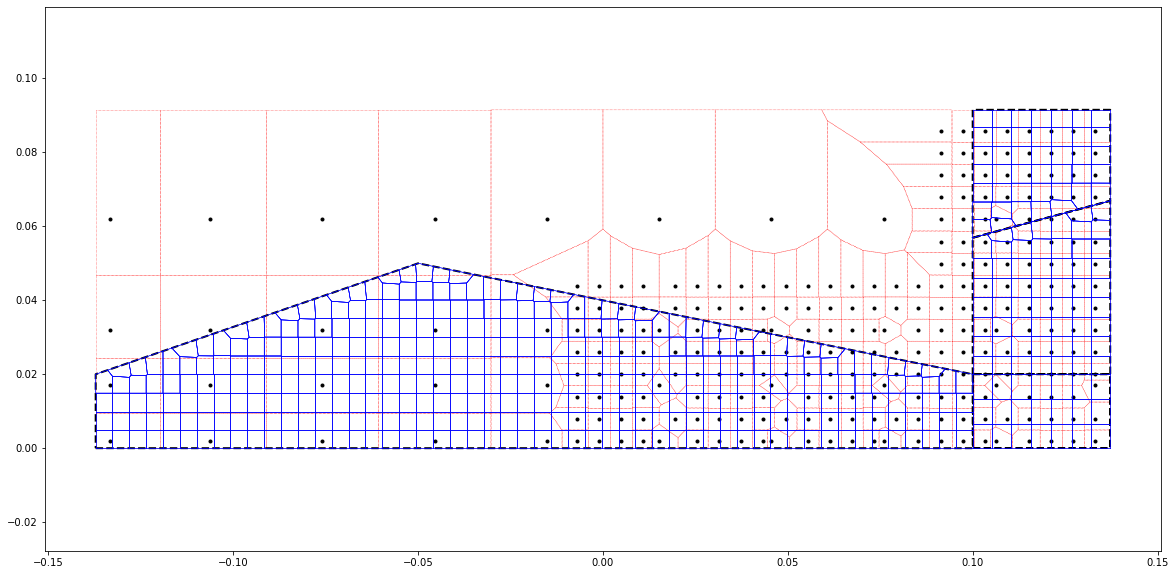

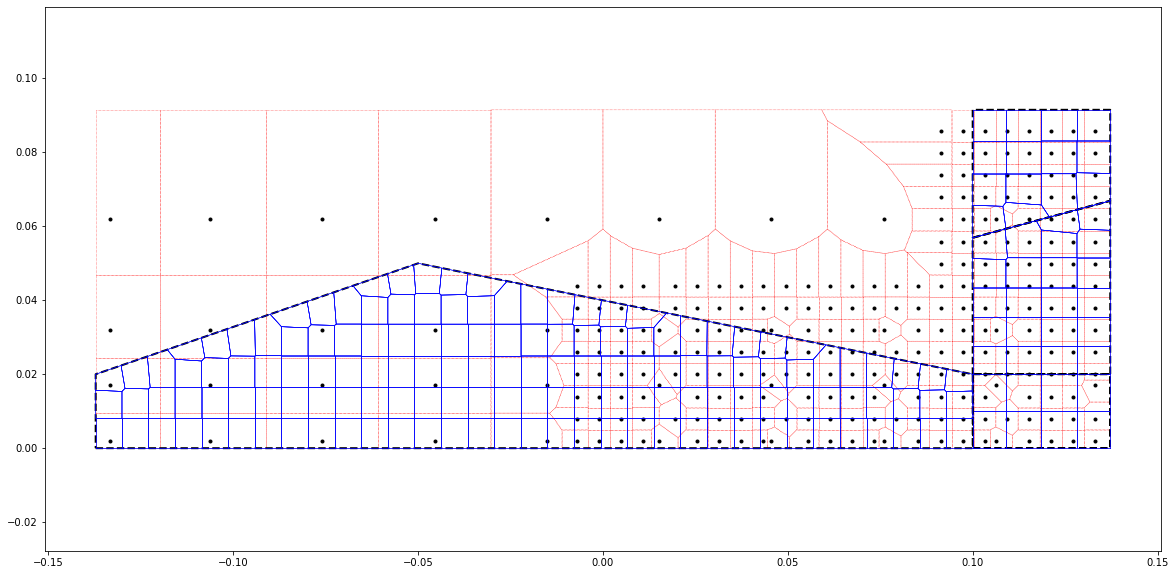

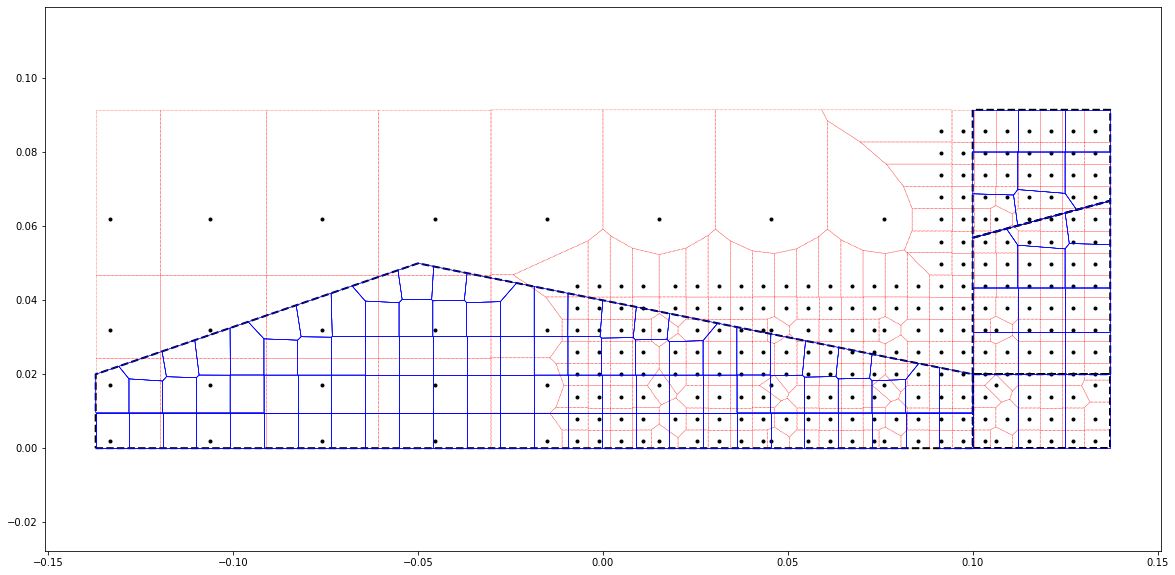

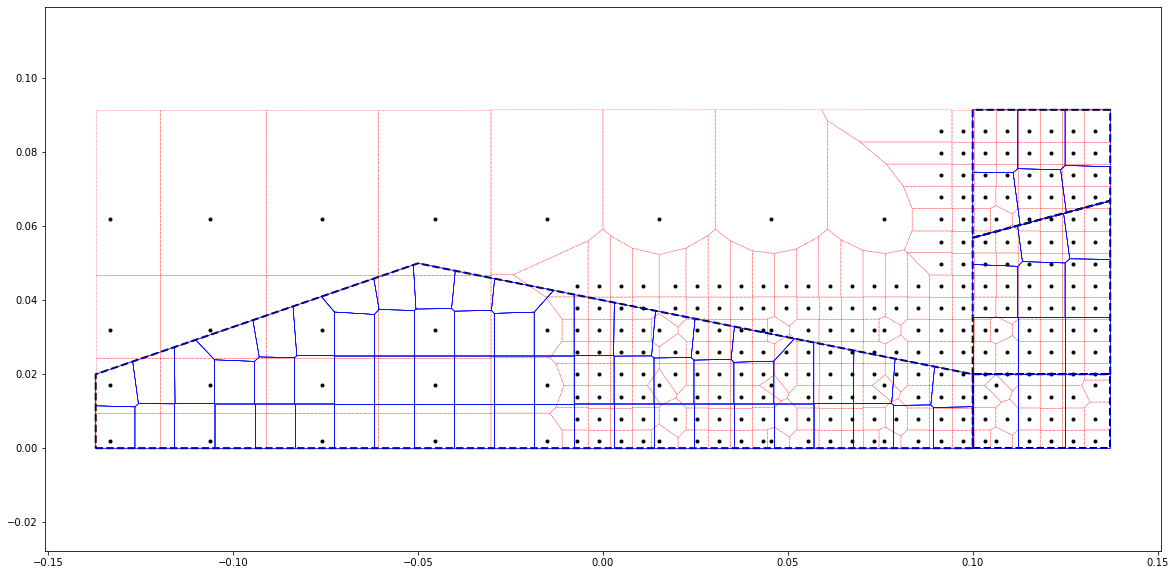

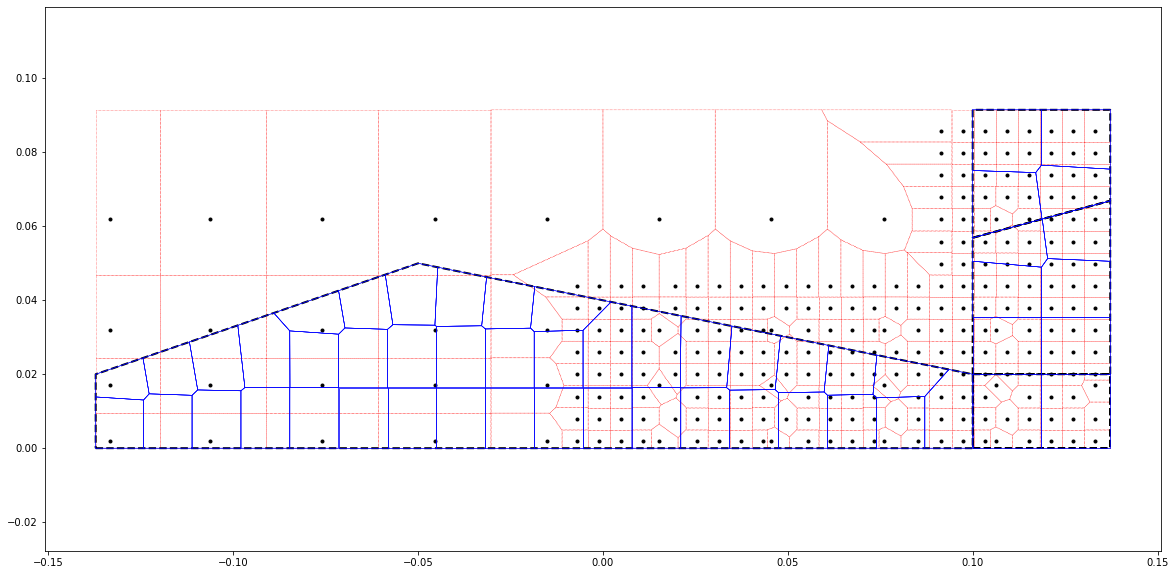

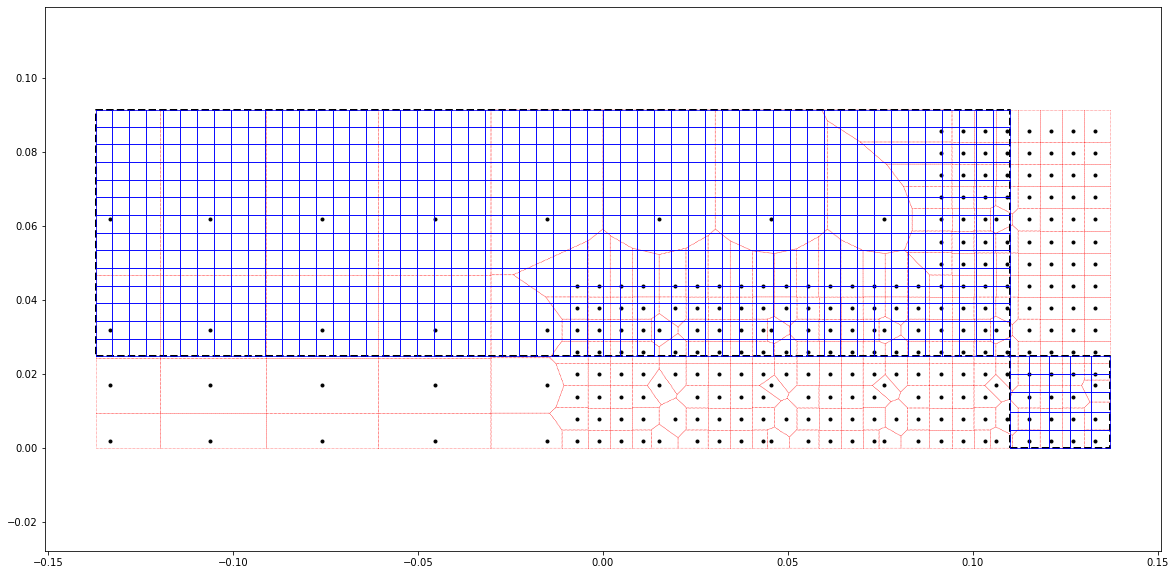

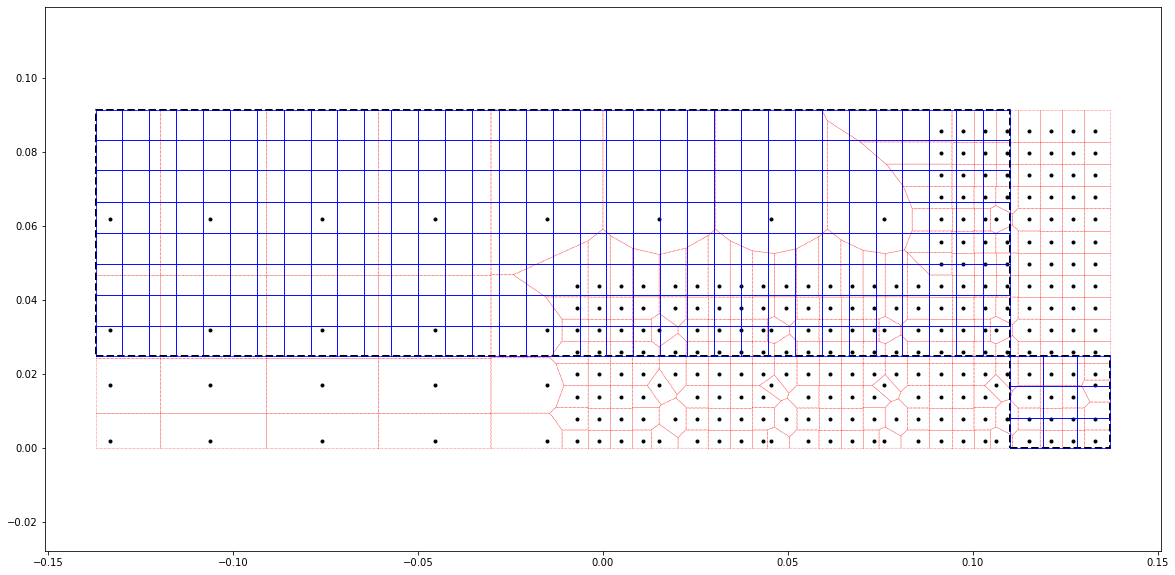

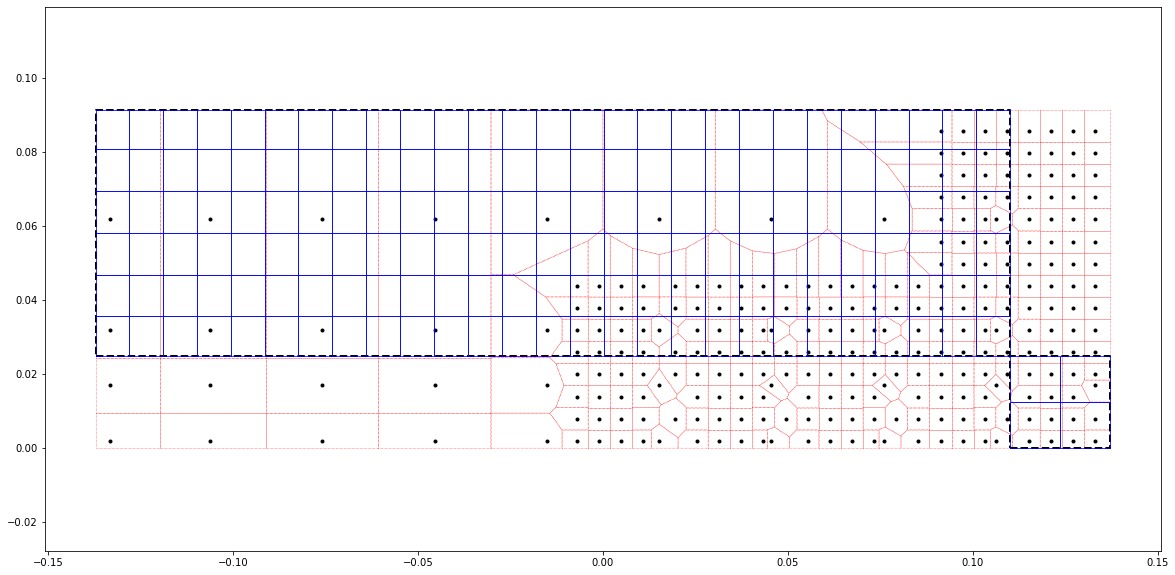

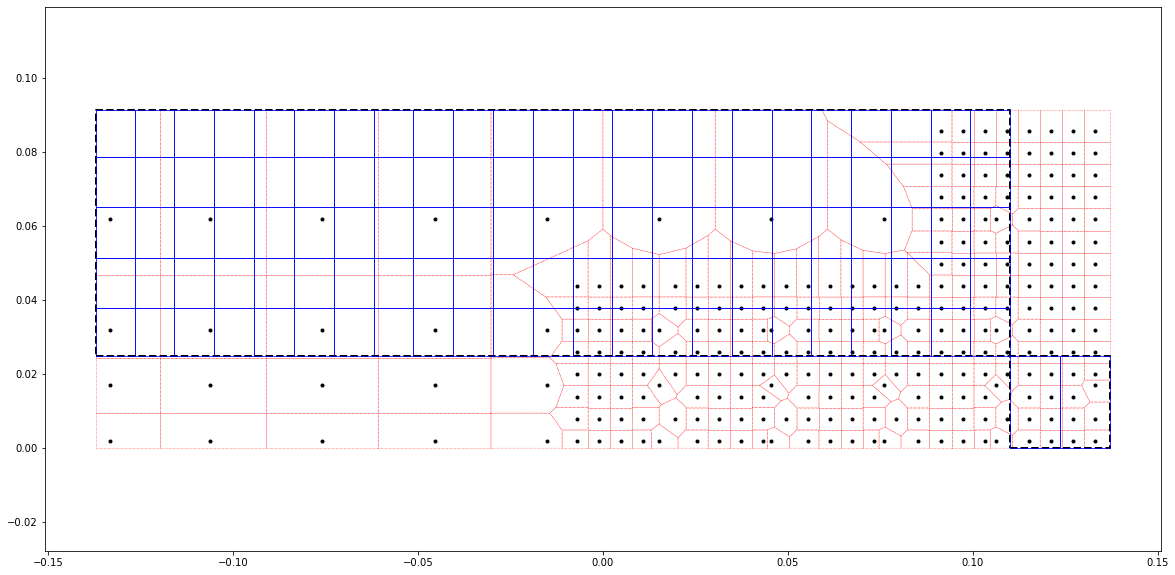

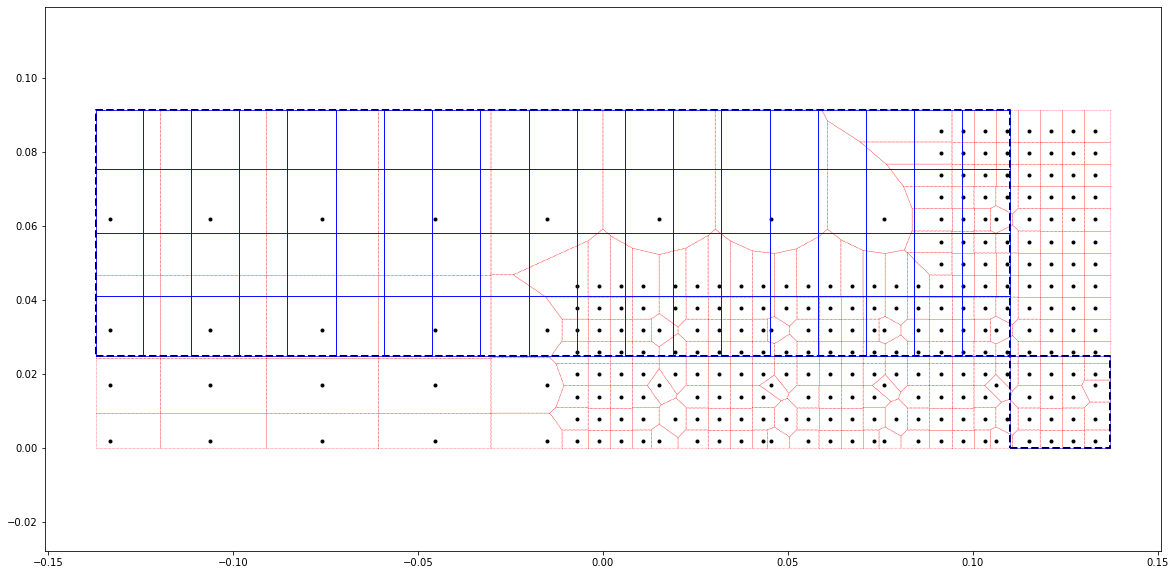

In [3]:
# print(myface.tapTribs)
print(f"Shape of 'panels': {np.shape(np.array(myface.panels,dtype=object))}")
print(f"Shape of 'pnlWeights': {np.shape(np.array(myface.tapWghtPerPanel,dtype=object))}")
print(f"Shape of 'tapIdxByPnl': {np.shape(np.array(myface.tapIdxPerPanel,dtype=object))}")

print(myface.nominalPanelAreas)
# plot panels
for c,code in enumerate(myface.zones):
    for a,area in enumerate(myface.nominalPanelAreas):
        plt.figure(figsize=[20,10])
        plt.plot(taps[:,0],taps[:,1],'.k')
        for t in myface.tapTribs.geoms:
            x,y = t.exterior.xy
            plt.plot(x,y,':r',lw=0.5)
        for z,zone in enumerate(code):
            for subzone in zone:
                plt.plot(subzone[:,0],subzone[:,1],'--k',lw=2.0)
            for p in myface.panels[c][z][a]:
                # print(p)
                x,y = p.exterior.xy
                plt.plot(x,y,'-b',lw=0.5)
        plt.axis('equal')
        plt.show()